In [1]:
import os
import re
import cv2
import sys
import glob
import pandas as pd
import numpy as np
sys.path.append("../table/")
sys.path.append("../")
sys.path.append("../stripes/")

import table
import neighbours
from stripes.palette import targets_dict

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_image_with_number(image_name):
    """.../12/IMG_33341001.png -> (image, 12)"""
    assert os.path.isfile(image_name), "File not found"
    number = re.findall("/[0-9]{1,2}/", image_name)
    assert len(number) > 0, "Invalid filename"
    number = number[0][1:-1]
    image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    return image, int(number)

In [3]:
data = pd.read_csv("../../images/stripe experiments/compact/table_compact.csv", sep=',')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,N,GLU,BIL,KET,SG,BLO,PH,PRO,URO,NIT,LEU
0,0.png,100,1,80,1.020,-1,7.5,0,2.0,0,1
1,1.png,1000,2,40,1.030,4,6.0,3,4.0,1,3
2,2.png,500,-1,80,1.030,4,7.5,4,0.2,1,1
3,3.png,250,1,15,1.025,4,8.5,2,0.2,1,0
4,4.png,250,3,160,1.015,3,5.0,-1,4.0,1,3


In [4]:
import pickle as pkl
with open("compact_table_geometry.pkl", "rb") as f:
    table_geometry = pkl.load(f)
tabler = table.Table(**table_geometry)

In [5]:
def get_weighted_manhattan_distance_custom(img1,img2):
    """
    Current state:
    calculate mean values of channels of images img1, img2:
    and then calculate manhattan distance with weights over them.
    weights = [1,5,4] were chosen using grid search 
    (! both images should be in LAB color space !)
    
    Takes as input:
    
    - img1, img2 - numpy 3d arrays 
    
    Returns:
    
    - distance - float, distance between two input images
    """
    weights = [2.,5.,3.]
    
    qwidth1, qheight1 = img1.shape[1] / 2.0, img1.shape[0] / 2.0
    qwidth2, qheight2 = img2.shape[1] / 2.0, img2.shape[0] / 2.0
    lmargin1 = (img1.shape[1] - qwidth1) / 2
    rmargin1 = img1.shape[1] - lmargin1
    lmargin2 = (img2.shape[1] - qwidth2) / 2
    rmargin2 = img2.shape[1] - lmargin2    
    tmargin1 = (img1.shape[0] - qheight1) / 2
    bmargin1 = img1.shape[0] - tmargin1
    tmargin2 = (img2.shape[0] - qheight2) / 2
    bmargin2 = img2.shape[0] - tmargin2
        
    crop1 = img1[int(tmargin1): int(bmargin1), int(lmargin1): int(rmargin1), :]
    crop2 = img2[int(tmargin2): int(bmargin2), int(lmargin2): int(rmargin2), :]
    
    point1 = np.median(crop1,axis=(0,1))
    point2 = np.median(crop2,axis=(0,1))
    
    d = 0.
    
    for i in xrange(point1.shape[0]):
        d += weights[i]*np.abs(point1[i] - point2[i])
        
    return d

Failed to approx with 4 points
Unsuccessful fit of ../../images/stripe experiments/tests/0/IMG_#0_20170909_124633.jpg
Successful fit of ../../images/stripe experiments/tests/0/photo_#0_2017-09-09_12-47-32.jpg


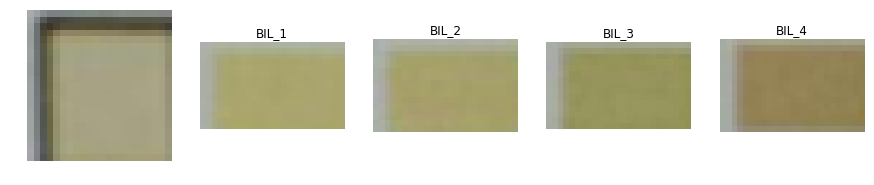

true label: 2, predicted label: 2


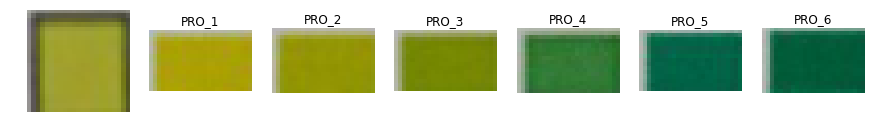

true label: 2, predicted label: 2


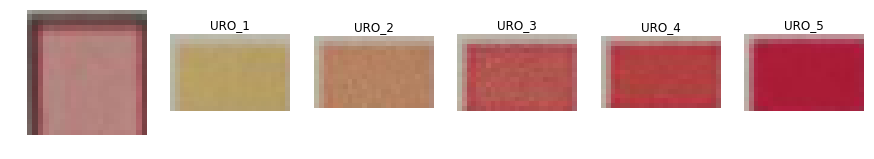

true label: 3, predicted label: 2


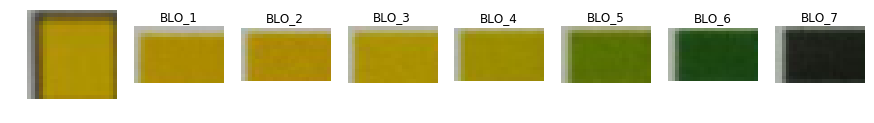

true label: 1, predicted label: 3


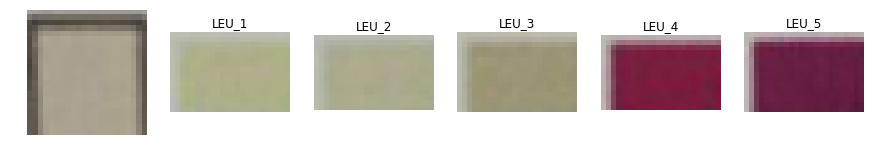

true label: 3, predicted label: 2


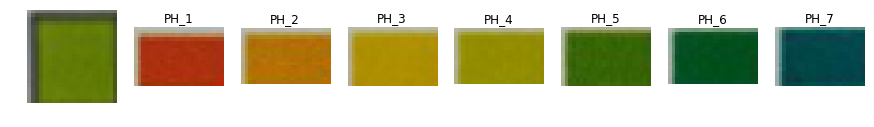

true label: 5, predicted label: 5


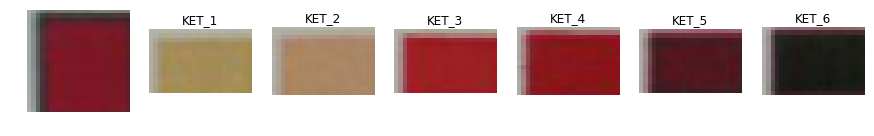

true label: 5, predicted label: 4


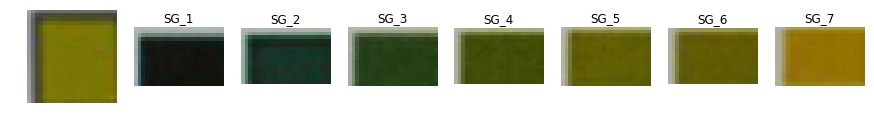

true label: 5, predicted label: 5


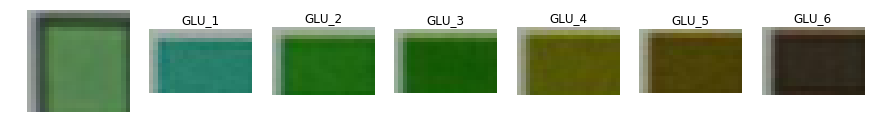

true label: 2, predicted label: 1


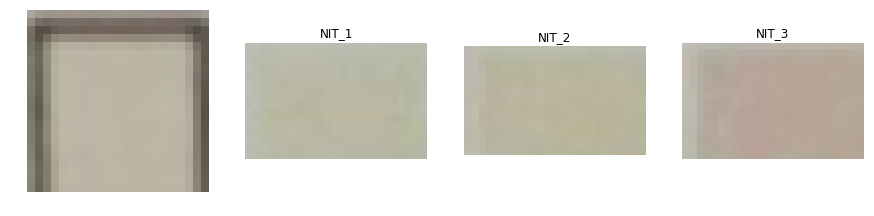

true label: 2, predicted label: 2
Successful fit of ../../images/stripe experiments/tests/0/photo_#0_2017-09-09_12-47-31.jpg


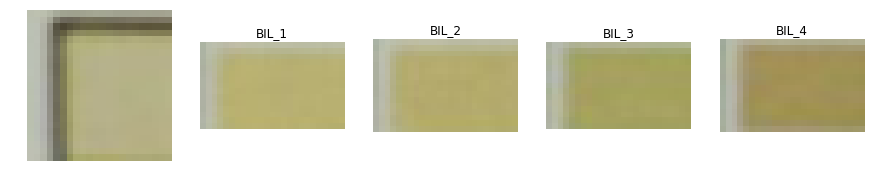

true label: 2, predicted label: 1


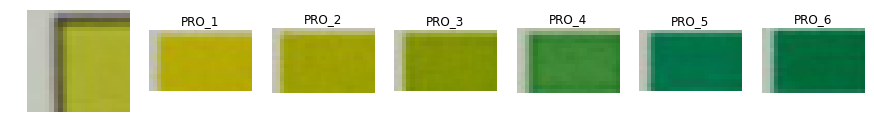

true label: 2, predicted label: 2


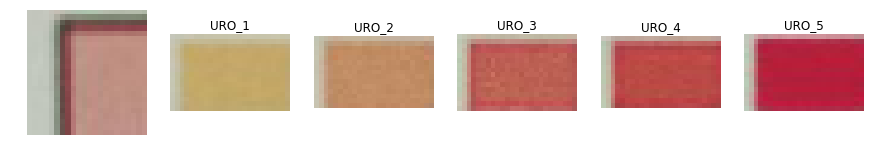

true label: 3, predicted label: 2


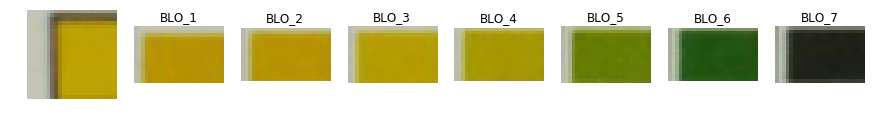

true label: 1, predicted label: 3


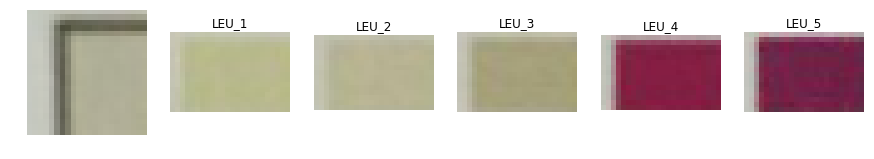

true label: 3, predicted label: 3


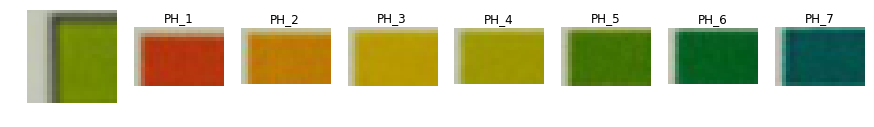

true label: 5, predicted label: 4


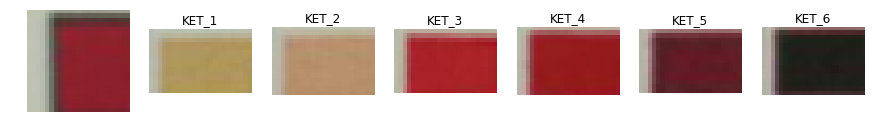

true label: 5, predicted label: 4


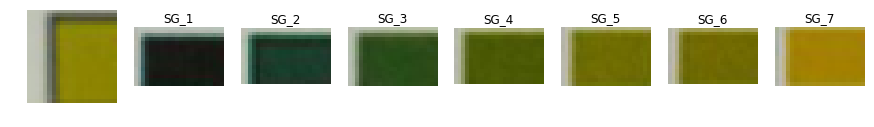

true label: 5, predicted label: 5


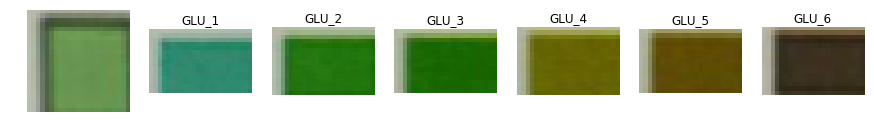

true label: 2, predicted label: 1


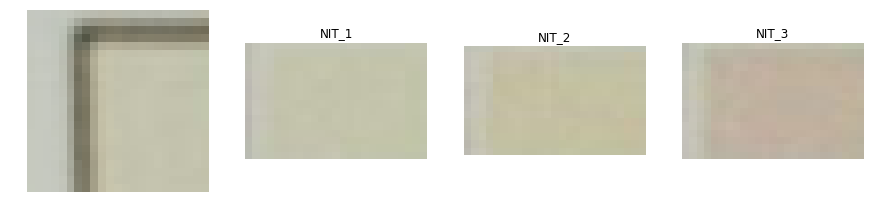

true label: 2, predicted label: 2
Failed to approx with 4 points
Unsuccessful fit of ../../images/stripe experiments/tests/0/photo_#0_2017-09-09_12-47-35.jpg
Successful fit of ../../images/stripe experiments/tests/0/photo_#0_2017-09-09_12-47-29.jpg


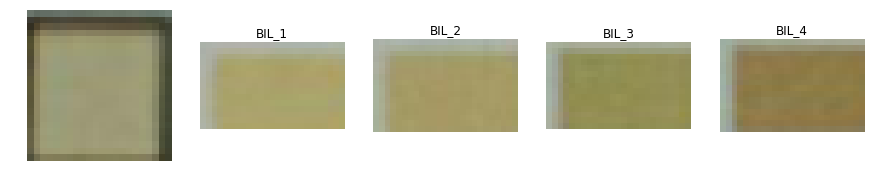

true label: 2, predicted label: 2


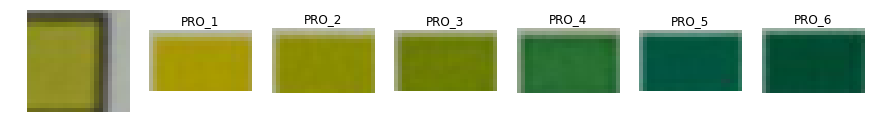

true label: 2, predicted label: 2


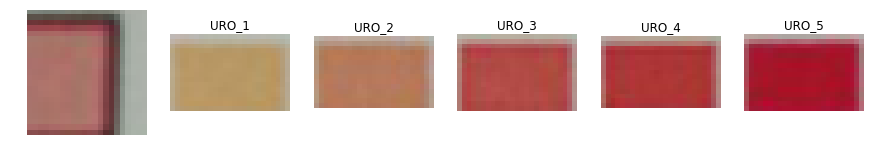

true label: 3, predicted label: 2


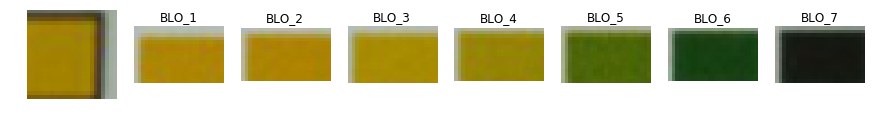

true label: 1, predicted label: 4


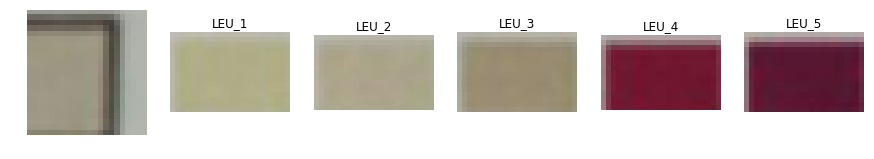

true label: 3, predicted label: 3


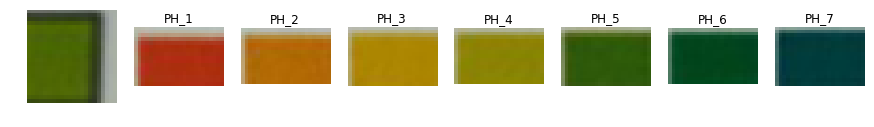

true label: 5, predicted label: 5


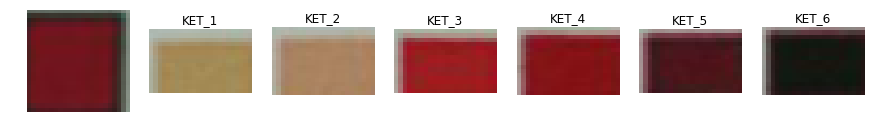

true label: 5, predicted label: 4


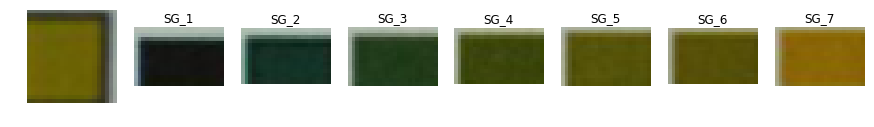

true label: 5, predicted label: 6


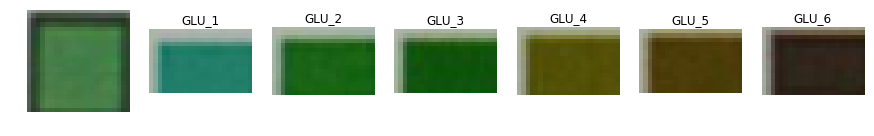

true label: 2, predicted label: 1


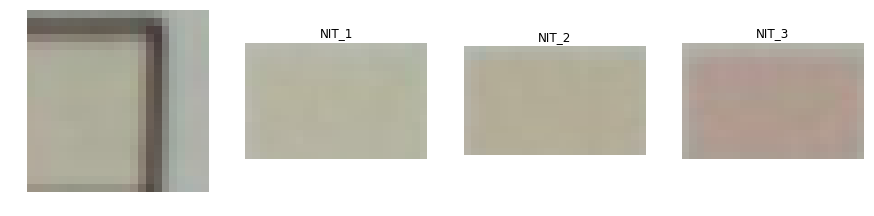

true label: 2, predicted label: 1
Successful fit of ../../images/stripe experiments/tests/0/IMG_#0_20170909_124700.jpg


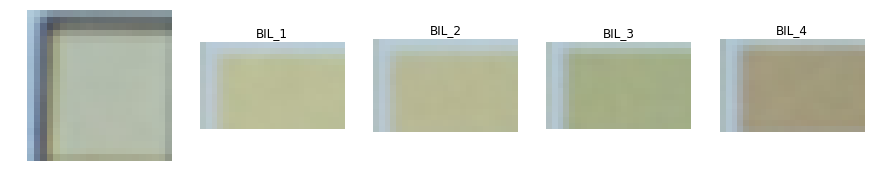

true label: 2, predicted label: 1


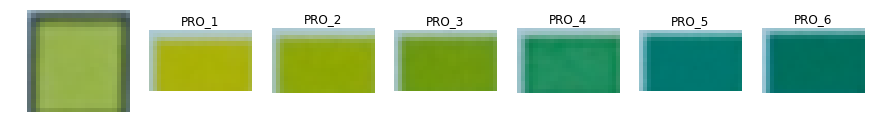

true label: 2, predicted label: 2


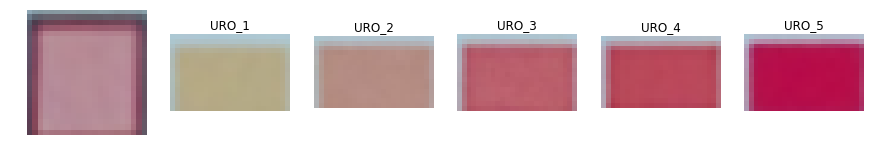

true label: 3, predicted label: 2


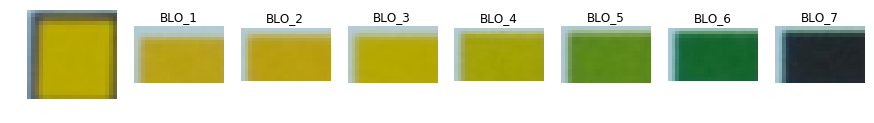

true label: 1, predicted label: 3


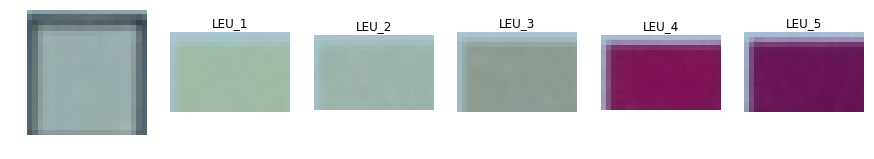

true label: 3, predicted label: 2


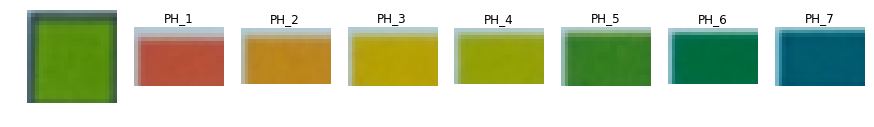

true label: 5, predicted label: 5


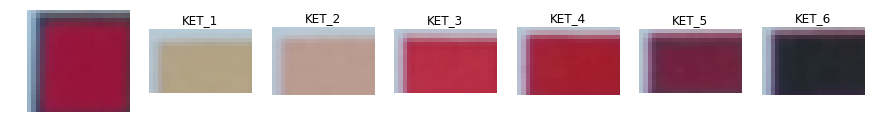

true label: 5, predicted label: 4


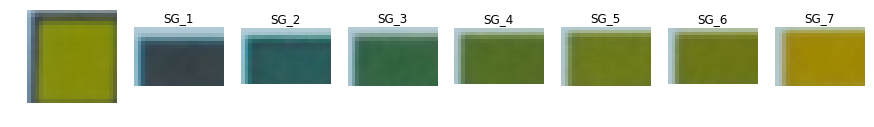

true label: 5, predicted label: 5


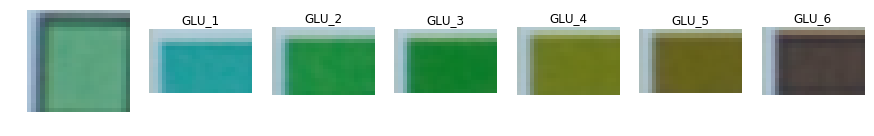

true label: 2, predicted label: 1


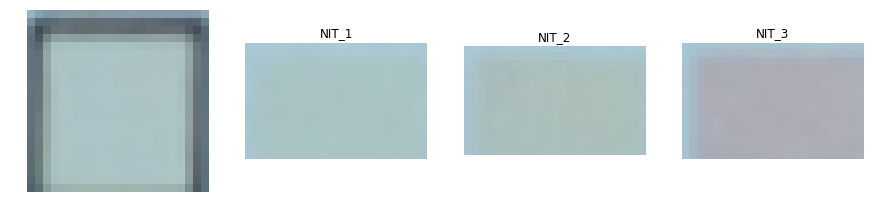

true label: 2, predicted label: 1
Successful fit of ../../images/stripe experiments/tests/0/photo_#0_2017-09-09_12-47-30.jpg


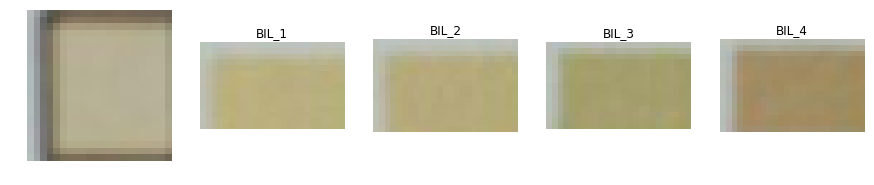

true label: 2, predicted label: 2


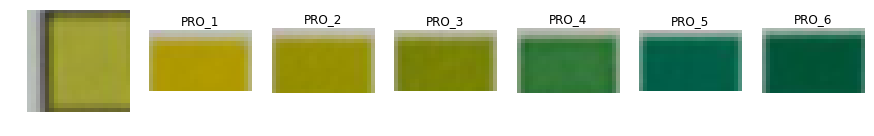

true label: 2, predicted label: 2


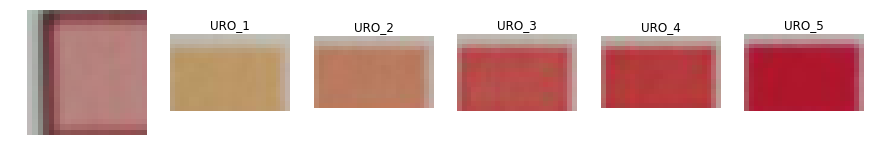

true label: 3, predicted label: 2


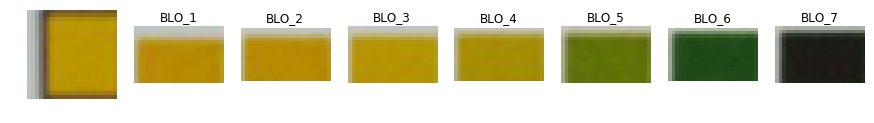

true label: 1, predicted label: 3


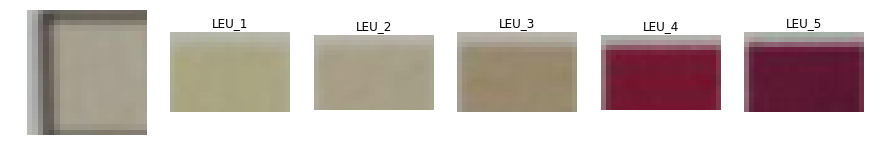

true label: 3, predicted label: 2


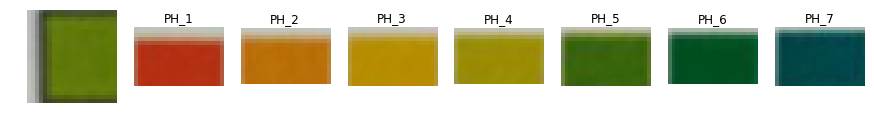

true label: 5, predicted label: 5


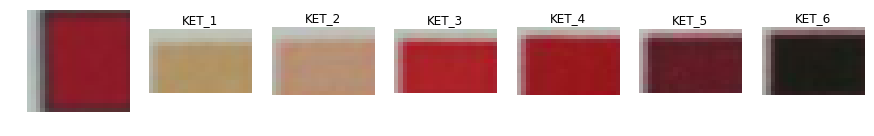

true label: 5, predicted label: 4


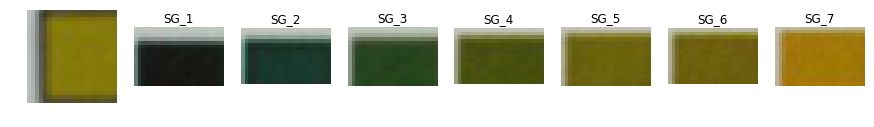

true label: 5, predicted label: 5


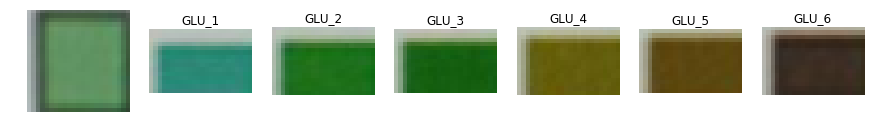

true label: 2, predicted label: 1


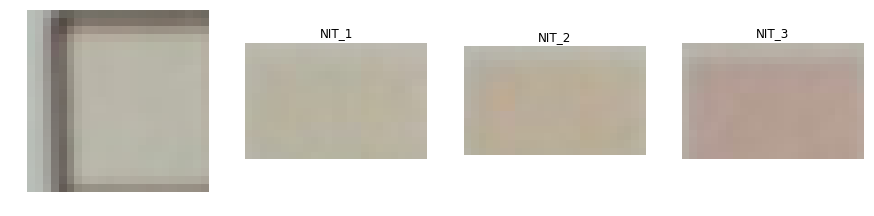

true label: 2, predicted label: 1
Successful fit of ../../images/stripe experiments/tests/0/IMG_#0_20170909_124555.jpg


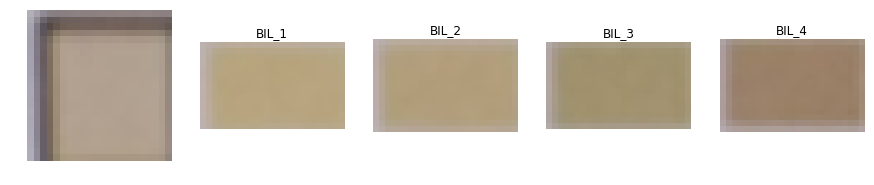

true label: 2, predicted label: 2


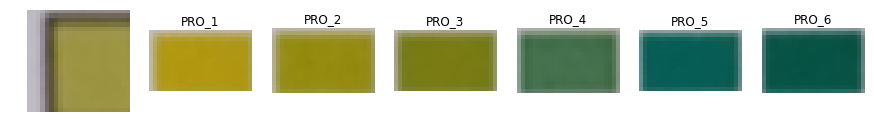

true label: 2, predicted label: 2


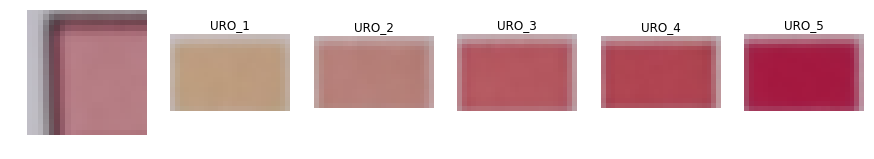

true label: 3, predicted label: 2


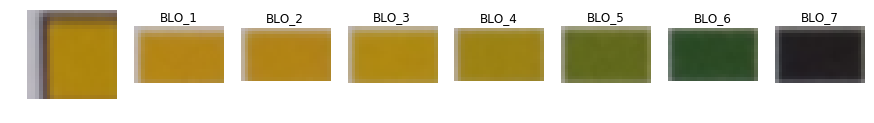

true label: 1, predicted label: 3


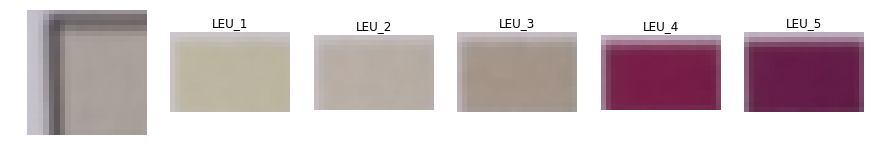

true label: 3, predicted label: 2


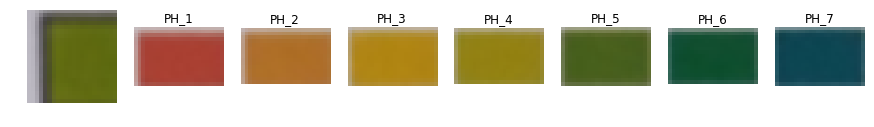

true label: 5, predicted label: 5


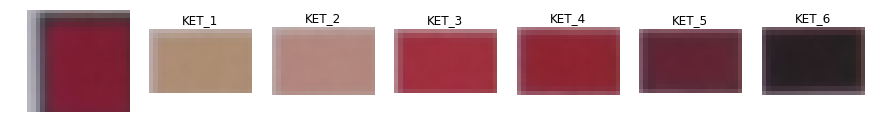

true label: 5, predicted label: 4


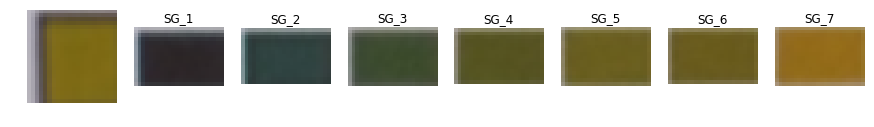

true label: 5, predicted label: 7


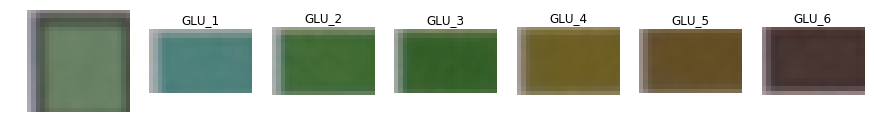

true label: 2, predicted label: 1


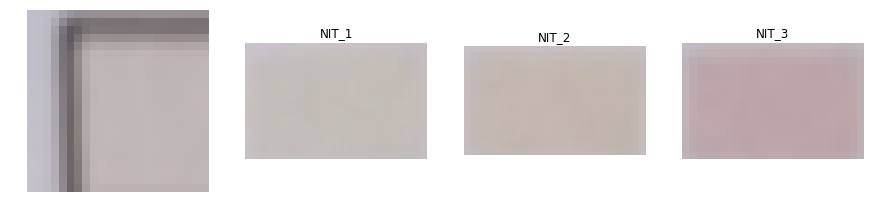

true label: 2, predicted label: 2
Failed to approx with 4 points
Unsuccessful fit of ../../images/stripe experiments/tests/0/IMG_#0_20170909_124732.jpg
Failed to approx with 4 points
Unsuccessful fit of ../../images/stripe experiments/tests/0/IMG_#0_20170909_124712.jpg
Successful fit of ../../images/stripe experiments/tests/0/photo_#0_2017-09-09_12-47-33.jpg


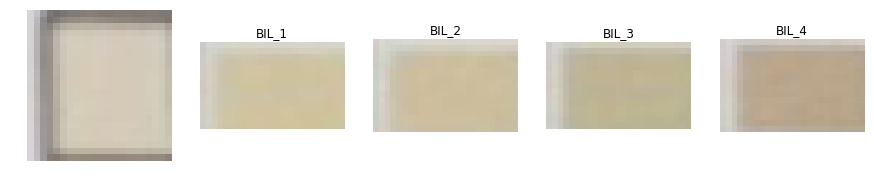

true label: 2, predicted label: 2


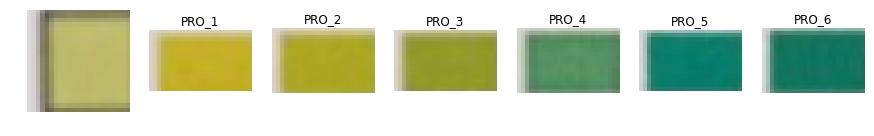

true label: 2, predicted label: 1


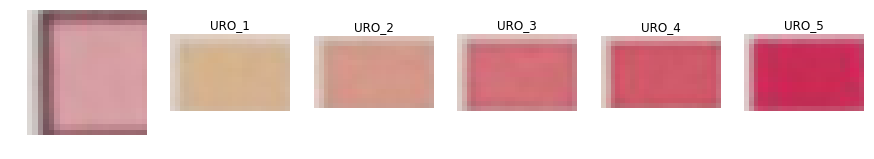

true label: 3, predicted label: 2


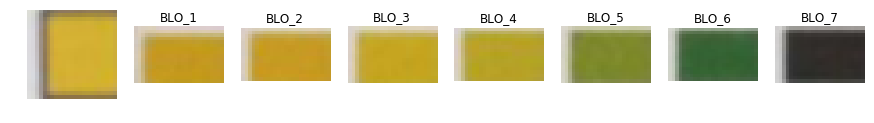

true label: 1, predicted label: 3


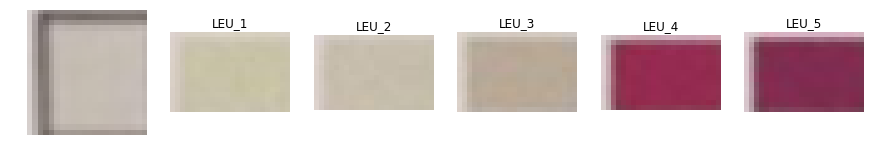

true label: 3, predicted label: 2


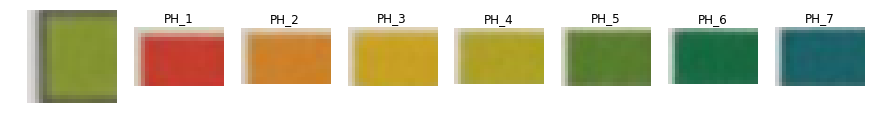

true label: 5, predicted label: 5


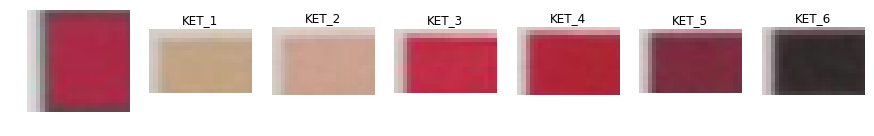

true label: 5, predicted label: 4


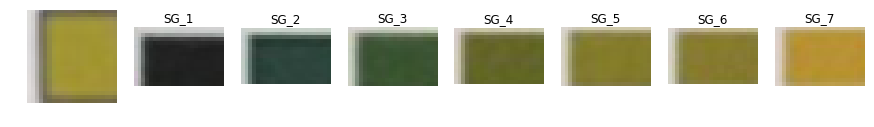

true label: 5, predicted label: 5


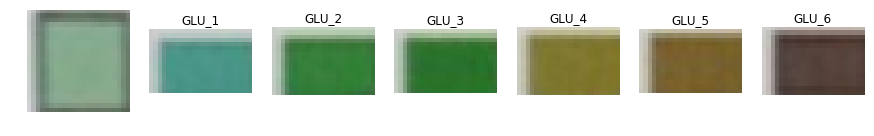

true label: 2, predicted label: 1


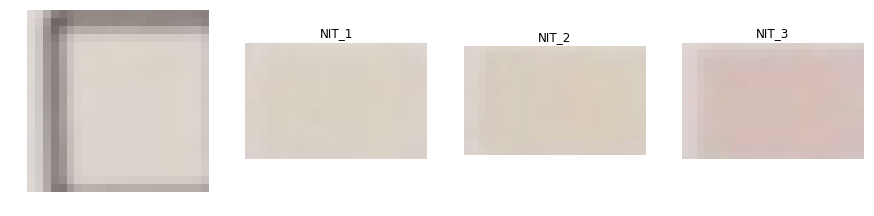

true label: 2, predicted label: 1


In [7]:
results_soft = []
results_hard = []

for image_name in glob.glob("../../images/stripe experiments/tests/0/*.*"):
    image, number = read_image_with_number(image_name)
    try:
        tabler.fit(image)
        palette = tabler.palette
        colorbar = tabler.colorbar
        print "Successful fit of {}".format(image_name)
        
    except:
        print "Unsuccessful fit of {}".format(image_name)
        continue
    for key_test, image_test in colorbar.iteritems():
        train = {}
        for key_train, image_train in palette.iteritems():
            if key_train.startswith(key_test):
                train.update({key_train: image_train})
#         print key_test, train.keys()
        
        plt.figure(figsize=(15, 4))
        plt.subplot(1, len(train) + 1, 1)
        plt.axis('off')
        plt.imshow(image_test)
        for j, key in enumerate(sorted(train.keys())):
            plt.subplot(1, len(train) + 1, j + 2)
            plt.axis('off')
            plt.title(key)
            plt.imshow(train[key])
        plt.show()
        y_pred, y_prob = neighbours.one_nearest_neighbor(train, image_test, get_distance=get_weighted_manhattan_distance_custom, return_probabilities=True, verbose=False)
        y_pred = int(y_pred[-1])
        y_true = targets_dict[key_test].index(data[key_test][number]) + 1
        results_hard.append(y_pred == y_true)
        results_soft.append(abs(y_pred - y_true) <= 1)
        print "true label: {}, predicted label: {}".format(y_true, y_pred)


In [8]:
print np.mean(results_hard)
print np.mean(results_soft)

0.385714285714
0.885714285714


In [ ]:
# Без кропа, среднее
# 0.471428571429
# 0.9

# Без кропа, медиана
# 0.514285714286
# 0.942857142857

# Кроп 1.3, среднее
# 0.485714285714
# 0.957142857143

# Кроп 1.7, среднее
# 0.485714285714
# 0.942857142857

# Кроп 2, среднее
# 0.442857142857
# 0.928571428571

# Кроп 1.3, медиана
# 0.414285714286
# 0.9

# Кроп 1.7, медиана
# 0.371428571429
# 0.9

# Кроп 2, среднее
# 0.385714285714
# 0.885714285714